In [3]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [32]:
data = loadmat('data/000.mat')
print(data['val'].shape)
sr = 360

(1, 4, 1500)


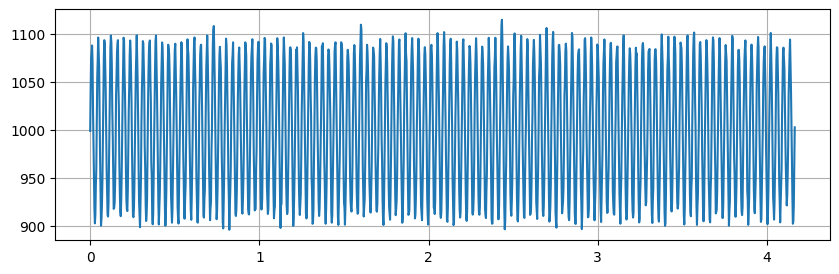

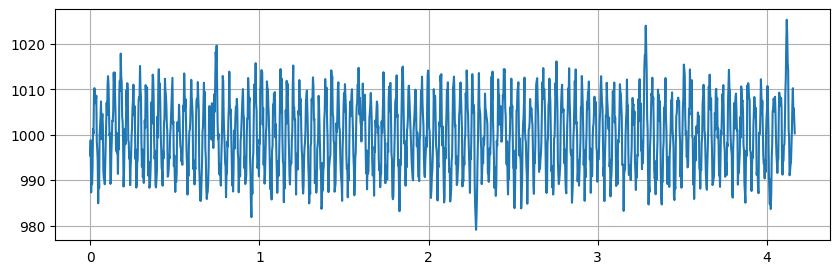

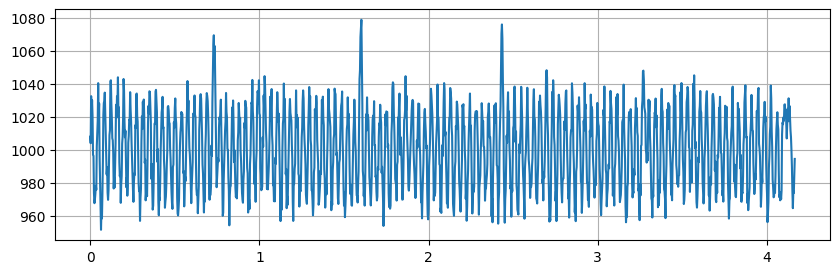

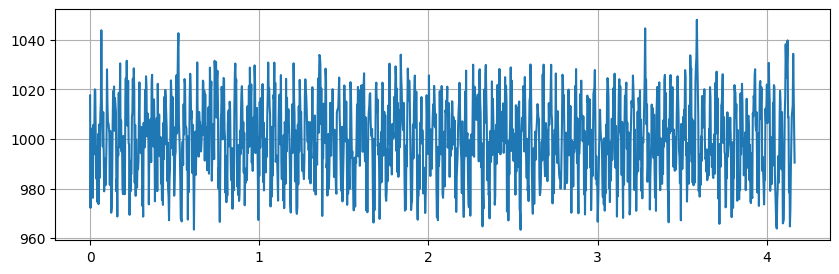

In [33]:
for i in range(4):
    plt.figure(figsize=(10, 3))
    d = data['val'][0][i]
    plt.plot(np.arange(0, len(d)/sr, 1/sr), d)
    plt.grid()
plt.show()